# Feature Selection with Categorical Data

## The two most commonly used feature selection methods for categorical input data when the target variable is also categorical (e.g. classification predictive modeling) are the chi-squared statistic and the mutual information statistic.

https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [172]:
# DermaDetect Copyright (C), 2021

from sklearn import tree
import pandas as pd
import pickle
import argparse
import os
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


In [173]:
import sklearn
print(sklearn.__version__)

0.24.2


In [174]:
data_relative_path = 'C:\\Users\\Tal Shushlav\\Documents\\Yael\\dd_data.csv'
data = pd.read_csv(data_relative_path)
data.head()

,age,pus,itch,size,shape,crater,gender,vesicle,bleeding,quantity,...,is_secondary_locations_toes,is_secondary_locations_toes_external,is_secondary_locations_toes_internal,is_secondary_locations_tongue,is_secondary_locations_upper_arm_external,is_secondary_locations_upper_arm_internal,is_secondary_locations_vaginal_region,is_secondary_locations_wrist_external,is_secondary_locations_wrist_internal,diagnosis
0,34.0,False,False,pea,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,True,eczema uns
1,41.0,False,False,unknown,unknown,False,female,False,False,unknown,...,False,False,False,False,False,False,False,False,False,contact dermatitis
2,25.0,False,False,pea,non-round,False,male,False,False,multiple,...,False,False,False,False,False,False,False,False,False,verruca vulgaris
3,49.0,False,True,>palm,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,False,tinea versicolor
4,21.0,False,False,pea,round,False,female,False,False,clustered,...,False,False,False,False,False,False,False,False,False,seborrheic dermatitis


In [204]:
data.dtypes

age                                          float64
pus                                             bool
itch                                            bool
size                                          object
shape                                         object
                                              ...   
is_secondary_locations_upper_arm_internal       bool
is_secondary_locations_vaginal_region           bool
is_secondary_locations_wrist_external           bool
is_secondary_locations_wrist_internal           bool
diagnosis                                      int32
Length: 106, dtype: object

In [175]:
# how many labels per each feature:
for col in data.columns:   
    print(col, ': ', len(data[col].unique()), 'labels')

age :  105 labels
pus :  2 labels
itch :  2 labels
size :  5 labels
shape :  3 labels
crater :  2 labels
gender :  2 labels
vesicle :  2 labels
bleeding :  2 labels
quantity :  5 labels
swelling :  2 labels
topography :  4 labels
temperature :  7 labels
duration.days :  8 labels
duration.from_birth :  1 labels
pain.is_pain :  2 labels
lossOfHair.type :  2 labels
lossOfHair.exist :  2 labels
pain.pain_type :  3 labels
location.coverage :  3 labels
is_texture_cracks :  2 labels
is_texture_dry :  2 labels
is_texture_exfoliation :  2 labels
is_texture_not_sure :  2 labels
is_texture_rough :  1 labels
is_texture_scales :  2 labels
is_texture_smooth :  1 labels
is_texture_wet :  2 labels
is_color_condition_black :  2 labels
is_color_condition_blue :  2 labels
is_color_condition_brown :  2 labels
is_color_condition_green :  2 labels
is_color_condition_grey :  2 labels
is_color_condition_normal :  2 labels
is_color_condition_purple :  2 labels
is_color_condition_red :  2 labels
is_color_condit

# look at the data

In [177]:
print(X.info())

#print(data[[data.isnull().sum()]])   # a list of the columns which have missing values
print(data.describe())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 107 entries, age to is_secondary_locations_wrist_internal
dtypes: bool(96), float64(3), object(8)
memory usage: 161.8+ KB
None
              age  temperature  duration.days
count  900.000000   900.000000     900.000000
mean    30.940651    36.615889     109.448889
std     18.886098     0.178184     146.951358
min      0.082000    36.600000       0.000000
25%     18.000000    36.600000       7.000000
50%     30.000000    36.600000      30.000000
75%     44.250000    36.600000      60.000000
max     90.000000    39.300000     365.000000


Index(['size', 'shape', 'gender', 'quantity', 'topography', 'lossOfHair.type',
       'pain.pain_type', 'location.coverage', 'diagnosis'],
      dtype='object')

# High number of missing data

In [178]:
X.isna().sum()       #How many NaN



age                                          0
pus                                          0
itch                                         0
size                                         0
shape                                        0
                                            ..
is_secondary_locations_upper_arm_external    0
is_secondary_locations_upper_arm_internal    0
is_secondary_locations_vaginal_region        0
is_secondary_locations_wrist_external        0
is_secondary_locations_wrist_internal        0
Length: 107, dtype: int64

In [179]:
X[['pain.pain_type', 'location.coverage']].head(10)    # columns with missing data

,pain.pain_type,location.coverage
0,NaN,NaN
1,on_pressure,part
2,on_pressure,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [180]:
X[['pain.pain_type', 'location.coverage']].isna().sum()    # count how many is NaN

pain.pain_type       746
location.coverage    845
dtype: int64

## drop features with missing data

In [184]:
#Drop dataframe columns based on NaN percentage
# Delete columns containing mor than 50%  NaN Values
#Keep only the rows with at least 50% non-NA values.
data = data.dropna( axis=1, thresh=450)
data.head(10)


,age,pus,itch,size,shape,crater,gender,vesicle,bleeding,quantity,...,is_secondary_locations_toes,is_secondary_locations_toes_external,is_secondary_locations_toes_internal,is_secondary_locations_tongue,is_secondary_locations_upper_arm_external,is_secondary_locations_upper_arm_internal,is_secondary_locations_vaginal_region,is_secondary_locations_wrist_external,is_secondary_locations_wrist_internal,diagnosis
0,34.0,False,False,pea,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,True,eczema uns
1,41.0,False,False,unknown,unknown,False,female,False,False,unknown,...,False,False,False,False,False,False,False,False,False,contact dermatitis
2,25.0,False,False,pea,non-round,False,male,False,False,multiple,...,False,False,False,False,False,False,False,False,False,verruca vulgaris
3,49.0,False,True,>palm,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,False,tinea versicolor
4,21.0,False,False,pea,round,False,female,False,False,clustered,...,False,False,False,False,False,False,False,False,False,seborrheic dermatitis
5,22.0,False,False,pea,round,False,female,False,False,clustered,...,False,False,False,False,False,False,False,False,False,acne vulgaris
6,52.0,False,True,handwatch,round,False,male,False,False,single,...,False,False,False,False,False,False,False,False,False,psoriasis
7,12.0,False,False,handwatch,round,False,female,False,False,single,...,False,False,False,False,False,False,False,False,False,folliculitis
8,37.0,False,True,pea,round,True,female,False,False,single,...,False,False,False,False,False,False,False,False,False,insect bite
9,55.0,False,True,>palm,non-round,False,female,True,False,multiple,...,False,False,False,False,True,False,False,False,False,urticaria


# drop the columns which only have a single unique value:

In [246]:
# drop the columns which only have a single unique value:
nunique = data.nunique()
cols_to_drop = nunique[nunique == 1].index
cols_to_drop
data = data.drop(cols_to_drop, axis=1)
data.head()

,age,pus,itch,size,shape,crater,gender,vesicle,bleeding,quantity,...,is_secondary_locations_thigh_external,is_secondary_locations_thigh_internal,is_secondary_locations_toes,is_secondary_locations_tongue,is_secondary_locations_upper_arm_external,is_secondary_locations_upper_arm_internal,is_secondary_locations_vaginal_region,is_secondary_locations_wrist_external,is_secondary_locations_wrist_internal,diagnosis
0,34.0,False,False,pea,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,True,4
1,41.0,False,False,unknown,unknown,False,female,False,False,unknown,...,False,False,False,False,False,False,False,False,False,3
2,25.0,False,False,pea,non-round,False,male,False,False,multiple,...,False,False,False,False,False,False,False,False,False,26
3,49.0,False,True,>palm,round,False,female,False,False,multiple,...,False,False,False,False,False,False,False,False,False,24
4,21.0,False,False,pea,round,False,female,False,False,clustered,...,False,False,False,False,False,False,False,False,False,20


# devide columns according to dtype

In [247]:
obj_columns = data.select_dtypes(include=['object', 'bool']).columns
print(obj_columns)
num_columns = data.select_dtypes(include=['float64']).columns
print(num_columns)
# bool_columns = data.select_dtypes(include=['bool']).columns
# bool_columns

Index(['pus', 'itch', 'size', 'shape', 'crater', 'gender', 'vesicle',
       'bleeding', 'quantity', 'swelling', 'topography', 'pain.is_pain',
       'lossOfHair.type', 'lossOfHair.exist', 'is_texture_cracks',
       'is_texture_dry', 'is_texture_exfoliation', 'is_texture_not_sure',
       'is_texture_scales', 'is_texture_wet', 'is_color_condition_black',
       'is_color_condition_blue', 'is_color_condition_brown',
       'is_color_condition_green', 'is_color_condition_grey',
       'is_color_condition_normal', 'is_color_condition_purple',
       'is_color_condition_red', 'is_color_condition_white',
       'is_color_condition_yellow', 'is_nailsdiseases_beau_s_lines',
       'is_nailsdiseases_clubbing', 'is_nailsdiseases_koilonychia__spooning_',
       'is_nailsdiseases_onycholysis', 'is_nailsdiseases_onychomycosis',
       'is_nailsdiseases_pitting', 'is_nailsdiseases_terry_s_nails',
       'is_nailsdiseases_yellow_nail_syndrome', 'is_primary_locations_arm',
       'is_primary_locatio

# Encoding the target

In [196]:
# Encode TARGET  features
#LabelEncode Target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()                                                     # initialize
data['diagnosis'] = le.fit_transform(data['diagnosis'])
y_name_mapping = dict(zip(le.fit_transform(le.classes_), le.classes_))  #translation of the encoding
y_name_mapping
  

{0: 'acne vulgaris',
 1: 'actinic keratosis',
 2: 'alopecia',
 3: 'contact dermatitis',
 4: 'eczema uns',
 5: 'folliculitis',
 6: 'hematoma uns',
 7: 'herpes simplex',
 8: 'insect bite',
 9: 'intertrigo',
 10: 'keratosis pilaris',
 11: 'melasma',
 12: 'molluscum contagiosum',
 13: 'onychomycosis',
 14: 'paronychia finger',
 15: 'pityriasis rosea',
 16: 'post inflammatory hyperpigmentation',
 17: 'psoriasis',
 18: 'rosacea',
 19: 'scar',
 20: 'seborrheic dermatitis',
 21: 'seborrheic keratosis',
 22: 'skin tag',
 23: 'tinea pedis',
 24: 'tinea versicolor',
 25: 'urticaria',
 26: 'verruca vulgaris',
 27: 'viral exanthem uns',
 28: 'vitiligo',
 29: 'xerosis cutis'}

# looking at numerical data

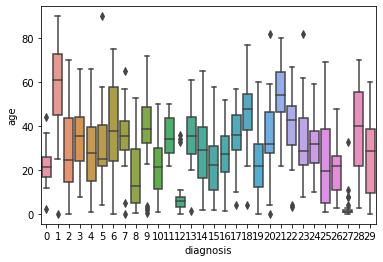

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.boxplot(x='diagnosis', y='age', data=data)
#plt.xticks(rotation=45)

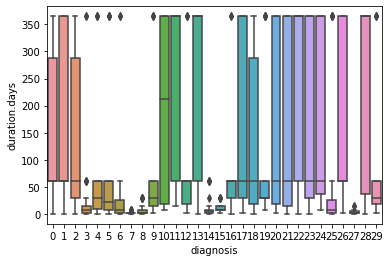

In [237]:
ax = sns.boxplot(x='diagnosis', y='duration.days', data=data)

## Transform and Create a pipeline

In [228]:
# for pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer
# make transformer
column_trans = make_column_transformer(
    (KBinsDiscretizer(n_bins=8), ['age']),          # creates bins fo  numerical features
    (OneHotEncoder(), obj_columns), remainder='passthrough')
column_trans.fit_transform(X)


array([[  0. ,   0. ,   0. , ...,   1. ,  36.6, 365. ],
       [  0. ,   0. ,   0. , ...,   0. ,  36.6,  60. ],
       [  0. ,   0. ,   0. , ...,   0. ,  36.6,  14. ],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,  36.6, 365. ],
       [  0. ,   0. ,   0. , ...,   0. ,  36.6,  14. ],
       [  0. ,   0. ,   0. , ...,   0. ,  36.6,   1. ]])

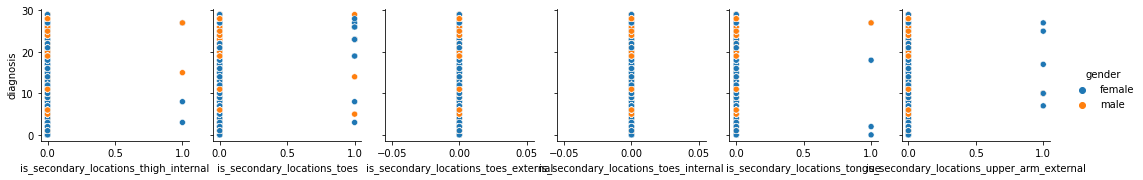

In [242]:
sns.pairplot(data, x_vars=['is_secondary_locations_thigh_internal', 'is_secondary_locations_toes',
       'is_secondary_locations_toes_external',
       'is_secondary_locations_toes_internal', 'is_secondary_locations_tongue',
       'is_secondary_locations_upper_arm_external'], y_vars=['diagnosis'], hue="gender")

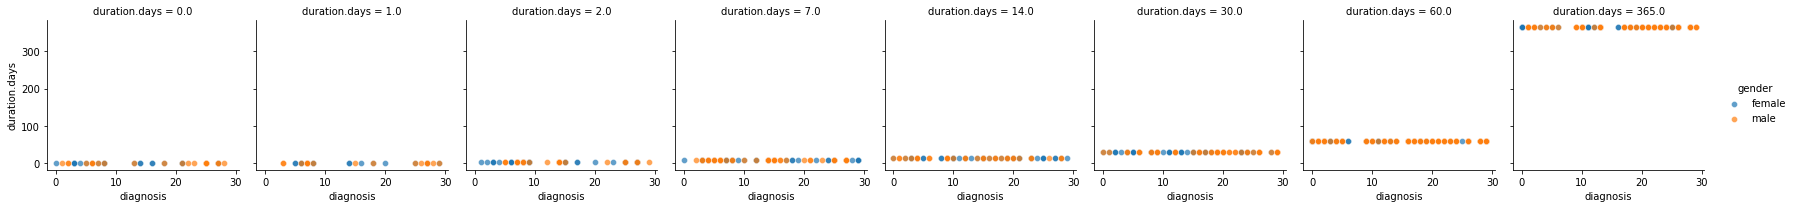

In [238]:
g = sns.FacetGrid(data, col="duration.days", hue="gender")
g.map(sns.scatterplot, "diagnosis", "duration.days", alpha=.7)
g.add_legend()

In [229]:
#create pipeline:                               # TODO fix
# pipe = make_pipeline(column_trans, logreg)
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

In [233]:
# split into input (X) and output (y) variables
X = data.iloc[:, :-1]
print(y[:5])


[ 4  3 26 24 20]


## Cross validation

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X = data.loc[:, ['age']]         # numerical

print(X.shape)
print(y.shape)

logreg = LogisticRegression(solver='lbfgs')

cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()
print(y.value_counts(normalized=True))

(900, 1)
(900,)


C:\Networks\Python3.9\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Networks\Python3.9\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [189]:

ohe.fit(X['gender'])
print(ohe.categories_)

    age    pus   itch     size      shape  crater  gender  vesicle  bleeding  \
0  34.0  False  False      pea      round   False  female    False     False   
1  41.0  False  False  unknown    unknown   False  female    False     False   
2  25.0  False  False      pea  non-round   False    male    False     False   
3  49.0  False   True    >palm      round   False  female    False     False   
4  21.0  False  False      pea      round   False  female    False     False   

    quantity  ...  is_secondary_locations_thigh_internal  \
0   multiple  ...                                  False   
1    unknown  ...                                  False   
2   multiple  ...                                  False   
3   multiple  ...                                  False   
4  clustered  ...                                  False   

  is_secondary_locations_toes  is_secondary_locations_toes_external  \
0                       False                                 False   
1               

ValueError: Expected 2D array, got 1D array instead:
array=['female' 'female' 'male' 'female' 'female' 'female' 'male' 'female'
 'female' 'female' 'male' 'female' 'female' 'female' 'female' 'female'
 'female' 'male' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'male' 'female' 'female' 'female' 'male' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'male' 'female' 'male'
 'female' 'male' 'female' 'female' 'male' 'female' 'female' 'female'
 'male' 'female' 'male' 'female' 'female' 'male' 'female' 'male' 'female'
 'female' 'male' 'female' 'female' 'female' 'female' 'male' 'female'
 'female' 'male' 'male' 'male' 'female' 'female' 'male' 'male' 'female'
 'male' 'male' 'male' 'female' 'male' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'female' 'male' 'female' 'male' 'female' 'female' 'female' 'female'
 'male' 'female' 'female' 'male' 'female' 'female' 'female' 'male'
 'female' 'female' 'female' 'female' 'male' 'female' 'female' 'female'
 'female' 'male' 'male' 'female' 'female' 'male' 'female' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'male' 'male' 'female'
 'female' 'female' 'male' 'female' 'female' 'male' 'female' 'male'
 'female' 'female' 'female' 'female' 'male' 'male' 'male' 'female' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'male' 'male' 'female'
 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'male' 'male'
 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female'
 'female' 'male' 'male' 'male' 'female' 'male' 'female' 'female' 'female'
 'female' 'male' 'female' 'male' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'male' 'female' 'male' 'female' 'female'
 'female' 'female' 'female' 'male' 'female' 'male' 'male' 'male' 'female'
 'male' 'male' 'female' 'female' 'female' 'female' 'male' 'male' 'male'
 'male' 'female' 'male' 'female' 'female' 'female' 'male' 'male' 'female'
 'female' 'male' 'female' 'male' 'female' 'male' 'male' 'male' 'female'
 'female' 'male' 'female' 'female' 'female' 'male' 'male' 'female'
 'female' 'male' 'female' 'male' 'male' 'female' 'female' 'female'
 'female' 'female' 'female' 'male' 'female' 'female' 'female' 'female'
 'female' 'male' 'female' 'male' 'female' 'female' 'male' 'male' 'male'
 'male' 'female' 'female' 'male' 'female' 'female' 'male' 'female'
 'female' 'male' 'female' 'female' 'female' 'male' 'female' 'male'
 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'female'
 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'female'
 'female' 'female' 'female' 'male' 'female' 'male' 'female' 'male'
 'female' 'male' 'male' 'female' 'female' 'female' 'female' 'female'
 'male' 'female' 'female' 'male' 'female' 'female' 'female' 'female'
 'male' 'female' 'female' 'male' 'female' 'male' 'female' 'female'
 'female' 'female' 'male' 'male' 'male' 'female' 'female' 'female'
 'female' 'male' 'female' 'male' 'female' 'male' 'female' 'female' 'male'
 'male' 'female' 'female' 'male' 'female' 'male' 'male' 'male' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'female' 'female'
 'male' 'female' 'male' 'female' 'female' 'male' 'male' 'male' 'male'
 'male' 'male' 'female' 'male' 'male' 'male' 'female' 'male' 'female'
 'male' 'male' 'female' 'female' 'female' 'female' 'male' 'male' 'female'
 'female' 'female' 'male' 'female' 'male' 'male' 'female' 'female'
 'female' 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'male' 'female' 'female'
 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'female'
 'male' 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'male'
 'male' 'female' 'male' 'female' 'male' 'female' 'female' 'male' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'female' 'male'
 'female' 'female' 'female' 'male' 'female' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'male' 'male' 'male' 'female'
 'male' 'female' 'female' 'male' 'male' 'male' 'female' 'female' 'male'
 'female' 'female' 'female' 'male' 'female' 'male' 'male' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'male' 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'female'
 'male' 'female' 'female' 'female' 'female' 'female' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'male' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'male' 'male' 'female' 'female' 'male' 'male'
 'female' 'male' 'female' 'male' 'male' 'female' 'male' 'male' 'male'
 'female' 'male' 'male' 'female' 'female' 'female' 'male' 'female' 'male'
 'male' 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'female'
 'female' 'male' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'male' 'male' 'female' 'female' 'female' 'female' 'male' 'female' 'male'
 'female' 'male' 'female' 'female' 'female' 'male' 'male' 'female' 'male'
 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'male' 'male'
 'male' 'male' 'female' 'female' 'female' 'female' 'female' 'male'
 'female' 'male' 'male' 'male' 'female' 'female' 'female' 'male' 'male'
 'female' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'female' 'female' 'female' 'male' 'female' 'female' 'male' 'female'
 'female' 'male' 'female' 'female' 'male' 'male' 'female' 'female' 'male'
 'male' 'male' 'female' 'female' 'female' 'male' 'male' 'male' 'female'
 'male' 'female' 'male' 'female' 'male' 'male' 'male' 'female' 'male'
 'male' 'male' 'female' 'female' 'female' 'male' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'male' 'female' 'female'
 'female' 'female' 'male' 'female' 'female' 'female' 'male' 'female'
 'male' 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'male'
 'female' 'female' 'female' 'male' 'male' 'male' 'female' 'female'
 'female' 'female' 'male' 'male' 'female' 'female' 'female' 'male'
 'female' 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'male' 'female' 'male'
 'female' 'female' 'female' 'male' 'male' 'male' 'male' 'female' 'female'
 'male' 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'male'
 'male' 'male' 'male' 'female' 'male' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'female' 'female' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'male'
 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'female' 'female'
 'female' 'male' 'male' 'female' 'male' 'male' 'female' 'male' 'male'
 'female' 'male' 'male' 'female' 'female' 'female' 'male' 'male' 'male'
 'male' 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'female'
 'female' 'male' 'female' 'male' 'female' 'male' 'male' 'male' 'female'
 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'male'
 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'male'
 'female' 'male' 'female' 'female' 'female' 'female' 'female' 'male'
 'male' 'female' 'female' 'female' 'male' 'male' 'male' 'male' 'female'
 'male' 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'male'
 'female' 'male' 'male' 'male'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
ax = sns.boxplot(x='diagnosis', y='temperature', data=data)

In [ ]:
data.loc[data['temperature'] > 37.0, 'diagnosis']

In [ ]:
duration.days

# Cross validation: temperature/ diagnosis


In [ ]:
# Encode Y w OneHotEncoder
X = data.loc[:, ['temperature']]         # numerical
y = data.diagnosis
print(X.shape)
print(y.shape)


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=5, scoring='accuracy')

In [ ]:
#LabelEncode pain.pain_type
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # initialize
print(X['pain.pain_type'].head())
data['pain.pain_type'] = le.fit_transform(data['pain.pain_type'])    # All NaN will be 2


In [ ]:

sns.scatterplot(x='diagnosis', y='pain.pain_type', data=data)
plt.xticks(rotation=45)

In [ ]:
sns.countplot(x='vesicle', data=data)           #Show the counts of observations in each categorical bin using bars.

Show value counts for two categorical variables:

In [ ]:
ax = sns.countplot(x="quantity", hue="vesicle", data=data)

# preprocessing encoding

In [186]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder   # יש חשיבות וסדר לנתונים (לדוגמה שנות לימוד)
print(obj_columns)
# prepare input data

column_trans= make_column_transformer(
    (OrdinalEncoder(), ['diagnosis']), remainder='passthrough')    # instanciate OrdinalEncoder to Encode categorical features as an integer array.
     
#oh = OneHotEncoder()
column_trans.fit_transform(X)



Index(['size', 'shape', 'gender', 'quantity', 'topography', 'lossOfHair.type',
       'pain.pain_type', 'location.coverage', 'diagnosis'],
      dtype='object')


NameError: name 'make_column_transformer' is not defined

In [ ]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [ ]:
# Correlation with the target:
absCorrWithDep = []
allVars = X.columns
print(allVars)
for var in allVars:
    absCorrWithDep.append(abs(y.corr(X[var])))


# split the data for training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)


### We can use the OrdinalEncoder() from scikit-learn to encode each variable to integers. This is a flexible class and does allow the order of the categories to be specified as arguments if any such order is known.
The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the train and test datasets.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
# EXAMPLE FOR ENCODE:
enc = OrdinalEncoder()
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)
print(enc.categories_)
enc.transform([['Female', 3], ['Male', 1]])


In [ ]:
from sklearn.preprocessing import OrdinalEncoder   # יש חשיבות וסדר לנתונים (לדוגמה שנות לימוד)
# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()     # instanciate OrdinalEncoder to Encode categorical features as an integer array.
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

## prepare the target variable - map the two class labels to 0 and 1 using LabelEncoder
This is a type of ordinal encoding, and scikit-learn provides the LabelEncoder class specifically designed for this purpose. We could just as easily use the OrdinalEncoder and achieve the same result, although the LabelEncoder is designed for encoding a single variable

In [ ]:
import numpy as np
np.unique(X_train[: ,2], return_counts=True)

In [ ]:
ordi = ["'0-4'", "'5-9'", "'10-14'", "'15-19'", "'20-24'", "'25-29'", "'30-34'",
        "'35-39'", "'40-44'", "'45-49'", "'50-54'"]                                    # assigning in the correct order

In [ ]:
# check where we need to order the list before LabelEncoder
for a in range (0, 9):
    print(a, ":", np.unique(X_train[: ,a]))
    

In [ ]:
from sklearn.preprocessing import LabelEncoder
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [ ]:

ordi = OrdinalEncoder(categories=[2])
ordi.fit(X-train[[]])

In [ ]:
np.unique(X_train[: ,3])

In [ ]:
np.unique(24-26, return_index=True)

In [ ]:
# call these functions to prepare our data:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)